<img src="images/ublogo.png"/>

### CSE610 - Bayesian Non-parametric Machine Learning

  - Lecture Notes
  - Instructor - Varun Chandola
  - Term - Fall 2020

### Objective
The objective of this notebook is to discuss non-parametric Bayesian methods for clustering.

<div class="alert alert-info">

**Note:** This material is loosely based on Chapter 2 of the lecture notes by [Orbanz](http://www.gatsby.ucl.ac.uk/~porbanz/papers/porbanz_BNP_draft.pdf).

</div>

Consider the problem of clustering where we are given $N$ instances, ${\bf x}_1,{\bf x}_2,\ldots,{\bf x}_N$ and the goal is partition this set into subsets, also referred to as **clusters**. The objective is to determine the partitions, such that instances belonging to the same cluster should be similar.

Consider the following example in which each observation is in $\mathbb{R}^2$ and $N = 1000$.

In [63]:
%run Utilities.ipynb

In [2]:
from sklearn.datasets import make_blobs

X,y = make_blobs(n_samples=1000, n_features=2,centers=3)

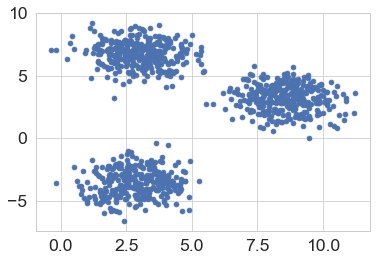

In [3]:
plt.scatter(X[:,0],X[:,1])

### From hard clustering to soft clustering

In the above data set, it is evident this data can be partitioned into three groups and the objective of a clustering method would be to assign to each observation a cluster label 1, 2 or 3. Such an assignment defines a partition of the index set {1, . . . , 1000} into three disjoint sets.

There are several clustering algorithms that can achieve the above objective, e.g., k-means.

However, the basic assumption for these methods is that every data instance belongs exactly to one cluster.

In probabilistic clustering, the clustering assignment, $z_i$ is treated as an unobserved random variable, where $z_i = k$ means that the data instance ${\bf x}_i$ belongs to cluster $k$.

We assume that $p_k()$ is the probability distribution of a cluster, indexed by $k$. Let $\pi_k$ denote the probability of a data instance to belong to cluster $k$. Obviously, 
$$
\sum_k \pi_k = 1
$$
Then the probability density of any instance, ${\bf x}$ can be written as:
$$
p({\bf x}) = \sum_{k=1}^K \pi_k p_k({\bf x})
$$
We will assume that each cluster-specific distribution, $p_k()$ is parameterized by a set of parameters, denoted by $\theta_k$.
#### Bayesian finite vs. infinite mixtures

In the above expression, we assume that $k$ ranges from 1 to $K$ where $K$ is finite. This is a **finite mixture model**. However, later we will consider cases where $K$ can go to $\infty$, also referred to as an **infinite mixture model**.

The generative process for a FMM is as follows:
\begin{eqnarray}
\boldsymbol{\pi}\vert\alpha & \sim & \text{Dir}(\alpha/K,\ldots,\alpha/K)\\
z_i\vert \boldsymbol{\pi} & \sim & \text{Cat}(\boldsymbol{\pi})\\
\theta_k\vert \lambda & \sim & G_0(\lambda)\\
x_i\vert z_i, \{\theta_k\}_{k=1}^K & \sim & F(\theta_{z_i})
\end{eqnarray}

Each observation $x_i$ is generated by first sampling a cluster index, $z_i$ from a Categorical distribution, parameterized by a $K$ length vector, $\boldsymbol{\pi}$. A symmetric Dirichlet prior is used to generate ${\bf \pi}$. The actual value is sampled from a cluster specific distribution, $F$, parameterized by $\theta_k$. The cluster specific distribution parameters are also generated from a prior (or base) distribution, $G_0$, parameterized by $\lambda$.

> What is a **Dirichlet distribution**: A random distribution, which is often considered as a multivariate generalization of the *Beta* distribution. The sample of a Dirichlet distribution is a $K$-length vector of values between 0 and 1, such that the values sum up to 1. The Dirichlet distribution is a conjugate prior of the categorical distribution and the Multinomial distribution. The parameter of the Dirichlet distribution is a $K$ length vector of positive values (also referred to as the *concentration parameters*).
>
> A special case of the Dirichlet distribution is the *symmetric Dirichlet Distribution* in which all values in the parameter vector are the same.


<BarContainer object of 4 artists>

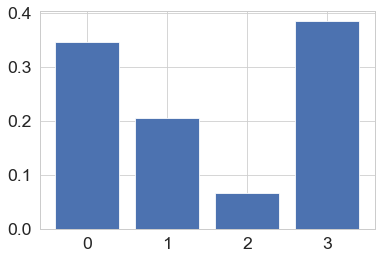

In [4]:
import scipy.stats as st
alpha = np.array([1,1,1,1])
plt.bar(np.arange(len(alpha)),dirichlet(alpha).rvs(1).flatten())

### Generating data according to a FMM
In the following example we will assume that $K$ is fixed to 6 (6 mixture components or clusters). We will assume that the data for each component is generated using a Gaussian distribution (i.e., $F \sim \mathcal{N}()$), and the data is 2-D. The prior distribution for generating the mixture parameters, i.e., $G_0$ will the Normal-inverse-Wishart distribution, that generates both mean and covariance matrices.

> The **Normal-inverse-Wishart** (NIW) distribution is a combination of a multivariate Gaussian (Normal) and an inverse Wishart distribution. The sample of NIW is a tuple - ($\boldsymbol{\mu},\Sigma$). The NIW is characterized by four parameters - ($\boldsymbol{\mu}_0,\lambda,\boldsymbol{\Psi},\nu$). The NIW is a *conjugate prior* for a multivariate Gaussian distribution.

In [55]:
mu0 = np.array([0,0])
lmbda = 1
Psi = np.eye(2)
nu = 2

mu, Sigma = normalinvwishartsample((mu0,lmbda,Psi,nu))
print('mu = ',mu)
print('Sigma = ',Sigma)

mu =  [[ 0.6549918 ]
 [-0.98404184]]
Sigma =  [[ 13.56563018 -15.85596617]
 [-15.85596617  20.6850535 ]]


Now we generate data for the FMM.

**Step 1: Sample $\boldsymbol{\pi}$ from the Dirichlet distribution**

In [6]:
D = 2
K = 6
alpha = 1
pi = dirichlet(alpha*np.ones((K,))).rvs(1).flatten()
print('pi = ',pi)

pi =  [0.06488614 0.61968345 0.07534602 0.17594264 0.03477439 0.02936736]


**Step 2: Sample the parameters for each component**

In [7]:
thetas = []
mu0 = np.array([0,0])
lmbda = 0.1
Psi = 2*np.eye(2)
nu = 6
for k in range(K):
    thetas.append(normalinvwishartsample((mu0,lmbda,Psi,nu)))

<a list of 11 text.Text objects>

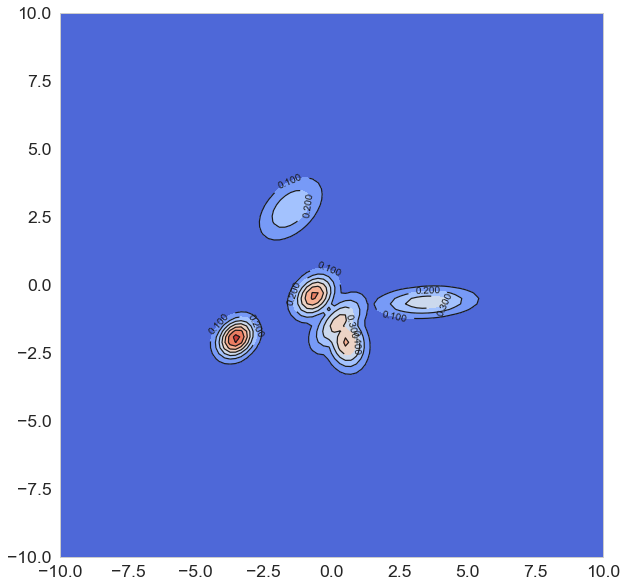

In [8]:
xmin,xmax,ymin,ymax = -10,10,-10,10
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
#ax.set_xlim(xmin, xmax)
#ax.set_ylim(ymin, ymax)

# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()]).T
pdfs = []
for i in range(K):
    mu = thetas[i][0]
    Sigma = thetas[i][1]
    pdfs_i = mvn(mu.flatten(),Sigma).pdf(positions)
    pdfs.append(pdfs_i)
pdfs = np.array(pdfs).T.max(axis=1)
pdfs = np.reshape(pdfs,xx.shape)
cfset = ax.contourf(xx, yy, pdfs, cmap='coolwarm')
ax.imshow(pdfs, cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, pdfs, colors='k')
ax.clabel(cset, inline=1, fontsize=10)

**Steps 3 and 4: For each data instance, first sample $z_i$ and then sample $x_i$**

In [9]:
zs = []
xs = []
N = 1000
for i in range(N):
    z_i = np.where(multinomial(1,pi).rvs(1).flatten())[0][0]
    zs.append(z_i)
    x_i = mvn(thetas[z_i][0].flatten(),thetas[z_i][1]).rvs(1)
    xs.append(x_i)
xs = np.array(xs)

In [10]:
# print number of instances assigned to each cluster
np.unique(zs,return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([ 50, 619,  68, 202,  37,  24]))

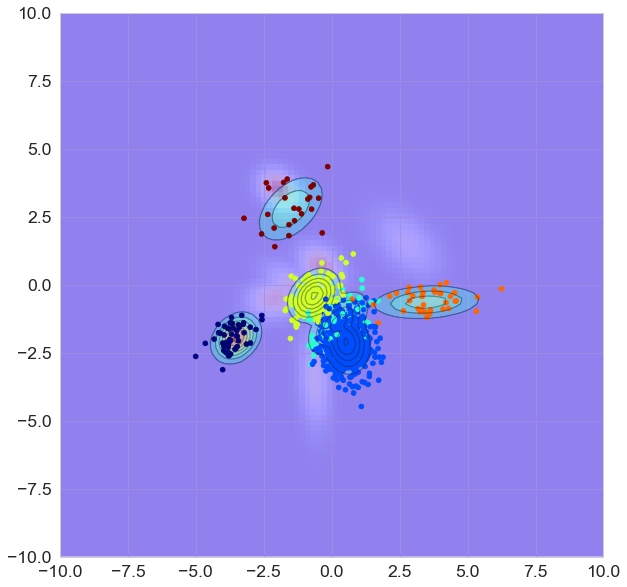

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()

cfset = ax.contourf(xx, yy, pdfs, cmap='rainbow',alpha=0.4)
ax.imshow(pdfs, cmap='coolwarm', extent=[xmin, xmax, ymin, ymax],alpha=0.4)
cset = ax.contour(xx, yy, pdfs, colors='k',alpha=0.4)
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
ax.scatter(xs[:,0],xs[:,1],c=zs,cmap='jet')

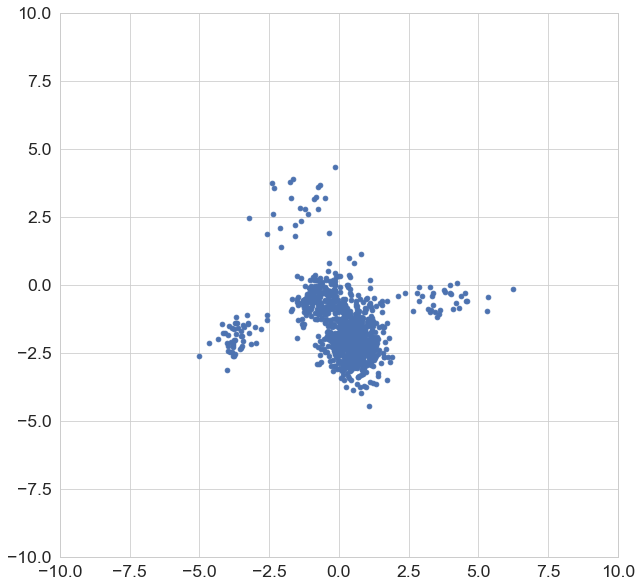

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()

ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
ax.scatter(xs[:,0],xs[:,1],cmap='jet')

## Generalizing to arbitrary number of clusters

If one lets $K$ go to $\infty$, FMM becomes a DPMM. However, in the case of DPMM, one can no longer use the multinomial distribution with a Dirichlet distribution prior to generate cluster assignments. This is because we do not fix the number of clusters in DPMM.

To achieve this, we will rely on the notion of a **Dirichlet Process**, which can be thought of as a generalization of a Dirichlet distribution.




So instead of sampling ${\bf \pi}$ from a Dirichlet distribution, we can use a generalized model (for now, referred to as a GEM), to give us ${\bf \pi}$ (of arbitrary length) and then follow the same strategy as the FMM.

The generative process can be written as:
\begin{eqnarray}
{\bf \pi}\vert\alpha & \sim & \text{GEM}(\alpha)\\
z_i\vert {\bf \pi} & \sim & \text{Cat}({\bf \pi})\\
\theta_k\vert \lambda & \sim & G_0(\lambda)\\
x_i\vert z_i, \{\theta_k\}_{k=1}^K & \sim & F(\theta_{z_i})
\end{eqnarray}


The ``GEM`` procedure above is a way to generalize the fixed length $\boldsymbol{\pi}$ to a possibly infinite length $\boldsymbol{\pi}$. We will actually look at three different ways to sample an arbitrary length $\boldsymbol{\pi}$. Next, we will discuss how to arrive at this procedure.

### Dirichlet Process
A dirichlet process is a stochastic process and can be thought of as a _probability distribution over probability distributions_. More formally, it is a distribution over probability measures.
> A *probability measure* is a function that assigns a value between 0 and 1 to an event. In this context, we will consider a space $\Theta$ and each event is a subset of $\Theta$. 

A dirichlet process or DP is parameterized by two parameters, a base distribution $G_0$ and a concentration parameter $\alpha$. $\alpha$ is a scalar positive value.

Consider any partitioning of the space, say $(A_1, A_2, \ldots, A_n)$. If $G$ is a sample from the DP distribution (prior), i.e., $G\sim DP(\alpha,G_0)$, then:
$$
G(A_1),G(A_2),\ldots,G(A_n) \sim \text{Dirichlet}(\alpha G_0(A_1),\alpha G_0(A_2),\ldots,\alpha G_0(A_n))
$$
Note that $n$ can be arbitrarily large. That is why DP is also an infinite-dimensional distribution.

Another way to understand DP is: The space, $\Theta$, can be partitioned into $n$ partitions in many ways. The probability measure $G$ assigns probability to each partition. But there can be many such $G$s. The DP prior models the distribution over all possible $G$s. 
<img src="images/thetaspace.jpg"/>

#### Intuition for using DP for clustering
Let $G$ be sampled from DP, i.e., $G\sim DP(\alpha,G_0)$. $G$ is a probability distribution over $\Theta$, i.e., it assigns a probability to any subset of $\Theta$. We can sample from $G$ and draw many i.i.d. samples from $G$, denoted by $\theta_1,\theta_2,\ldots,\theta_n \sim G$. Since the draws from a DP are also discrete distributions, we can write:
$$
G = \sum_{k=1}^\infty \pi_k \delta_{\theta = \theta_k}
$$
Here $\pi_k$ denotes the size of the $k^{th}$ partition and the $\delta()$ function takes 1 if $\theta = \theta_k$, and 0 otherwise. An interesting property here is that there is a positive probability of different samples to have the same $\theta_k$ which produces a clustering effect. More on this later.

Let us now see how to construct and represent a DP.

### Chinese restaurant process (CRP)
This analogy is often used to assigning observations to groups. Consider a restaurant in which the customers are arranged in the following way:

* Initially the restaurant is empty
* First customer selects an empty table (group) and sits down. The customer selects the food (parameters for data generated by that group) for that table. Any subsequent members of the table will be constrained to eat that food. 
* Second customer can either sit at an empty table with a probability $\frac{\alpha}{1+\alpha}$ (and order food, i.e., select parameters) or will sit with the previous customer with probability $\frac{1}{1+\alpha}$ (and share the food).
* The $(n+1)^{th}$ customer can either sit at an empty table with probability $\frac{\alpha}{n+\alpha}$ or sit at a non-empty table number $k$ with probability $\frac{n_k}{n+\alpha}$, where $n_k$ is the number of customers already sitting at that table.

In summary, one can write that:
$$
p(\phi_n = k|\phi_{1:n-1}) = \frac{n_k}{\alpha + n - 1}
$$
If the $k^{th}$ table is already occupied with $n_k$ customers sitting, and
$$
p(\phi_n = k|\phi_{1:n-1}) = \frac{\alpha}{\alpha + n - 1}
$$
If the $k^{th}$ table is empty.


In [217]:
def createNewTable(tables,newCustomerId):
    if len(tables) == 0:
        newTableId = 0
    else:
        newTableId = max(tables.keys()) + 1
    tables[newTableId] = [newCustomerId]
    return tables

In [218]:
def crp(numCustomers,alpha):
    tables = {}
    counts = []
    for n in range(1,numCustomers+1):
        if n == 0: # first customer
            createNewTable(tables,n)
        else:
            # create a probability vector and sample from that
            probVec = []
            # first entry will be for choosing a new table
            probVec.append(alpha/(n+alpha))
            # rest of the entries will be for joining existing tables
            for t in tables.keys():
                probVec.append(len(tables[t])/(n+alpha))
            # get a random choice using the probVec vector
            c = np.where(np.random.multinomial(1, probVec, size=1)[0] == 1)[0][0]
            if c == 0:
                createNewTable(tables,n)
            else:
                tables[c-1].append(n)
        counts.append(len(tables))
    return tables,counts

<BarContainer object of 11 artists>

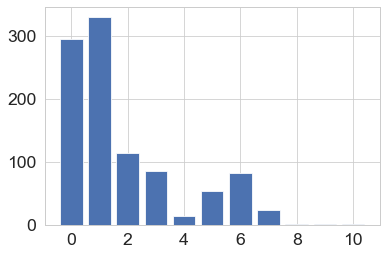

In [262]:
tables,counts = crp(1000,1)
tCounts = []
for t in tables.keys():
    tCounts.append(len(tables[t]))
plt.bar(range(len(tCounts)),tCounts)

#### Effect of $\alpha$ on number of tables created

In [220]:
tableCounts = []
for alpha in range(1000):
    tables,counts = crp(100,alpha)
    tableCounts.append(len(tables))

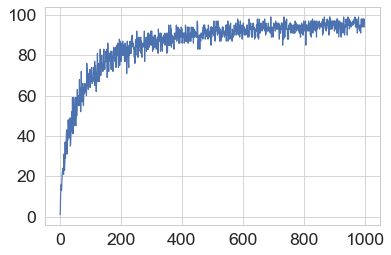

In [221]:
plt.plot(range(1000),tableCounts)

Clearly the number of tables (clusters) increases with increasing $\alpha$, which can be thought of as a _concentration parameter_. Higher value indicates more likelihood of creating new tables.

#### Impact of number of customers on the number of tables created

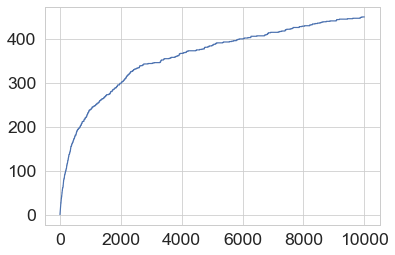

In [16]:
tables,counts = crp(10000,100)
plt.plot(counts)

### The Polya Urn [Blackwell and Macqueen] Model
A similar model uses a different metaphor for infinite clusters. Starting with an empty urn and a base distribution $G_0$, the model adds a new ball (sampled from the base distribution) with probability $\frac{\alpha}{\alpha + n}$ ($n$ is the number of balls currently in the urn), otherwise, it randomly picks a ball from the urn and adds another ball in the urn of the same color.

The polya-urn model is flexible in terms of the base distribution, $G_0$. If $G_0$ is categorical with finite number of possibilities, then the output is a sample from a Dirichlet distribution with concentration parameter $\alpha$. However, if the base distribution can yield infinite possibilities, then it converges to a Dirichlet process.

The probability of observing a ball, given a past sequence of $n-1$ balls, can be written as:
$$
\phi_n\vert\phi_{1:n-1}  \sim \frac{\alpha G_0}{\alpha + n - 1} + \frac{\sum_{j=1}^{n-1}\delta(\phi_n - \phi_j)}{\alpha + n - 1}
$$
where the quantity $\delta(x) = 1$, if $x = 0$, and $\delta(x) = 0$, otherwise.

The above result can be easily computed by considering the fact that the $n^{th}$ ball can either be a new draw from $G_0$ with probability $\frac{\alpha}{\alpha + n - 1}$ or can be sampled uniformly from the current $n-1$ balls with a probability $1 - \frac{\alpha}{\alpha + n - 1}$. The quantity $\sum_{j=1}^{n-1}\delta(\phi_n - \phi_j)$ counts the number of balls in the urn of the same color as $\phi_n$.



In [13]:
def polyaUrn(numBalls,alpha,baseDistribution,args=[]):
    urn = []
    for n in range(numBalls):
        # determine if a new ball needs to be sampled
        p = alpha/(alpha + n)
        c = np.random.binomial(1,p,1)[0]
        if c == 1 or n == 0:
            # add a new ball to the urn            
            newBall = baseDistribution(args)
            urn.append(newBall)
        else:
            # sample existing ball and add it back and another ball to the urn
            urn.append(urn[np.random.randint(len(urn))])
    return urn

In [14]:
def bd_normal(args):
    return np.random.normal(args[0],args[1])

In [23]:
def bd_uniform(args):
    return np.random.uniform(args[0],args[1])

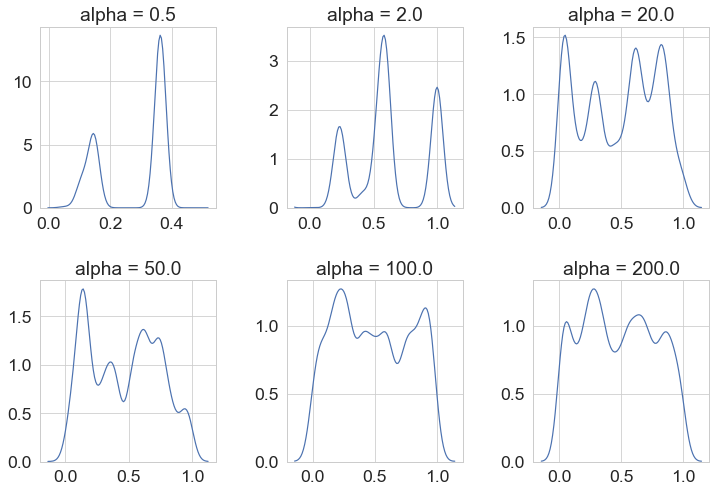

In [32]:
fig = plt.figure(figsize=[12,8])
fig.subplots_adjust(hspace=0.4, wspace=0.4)
i = 1

for alpha in (0.5,2,20,50,100,200):
    urn = polyaUrn(10000,alpha,bd_uniform,[0,1])
    ax = fig.add_subplot(2,3,i)
    sns.kdeplot(np.array(urn))
    #ax.bar(range(len(urn)),np.array(urn))
    ax.set_title('alpha = %.1f'%alpha)
    i += 1

In [19]:
urn = polyaUrn(10000,1,np.random.normal,[0,1])
np.unique(urn)

array([-1.08831949, -1.07721294, -0.68381687, -0.68281225, -0.38187558,
       -0.02831205,  0.72361783,  0.8940417 ])

It is evident above that as the concentration parameter increases, the output of the _poly-urn model_ starts resembling the base distribution. On the other hand, lower values of $\alpha$ exhibit a clustering effect.

Similar effect can be studied in a 2-D plot

/Users/chandola/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning:

Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.



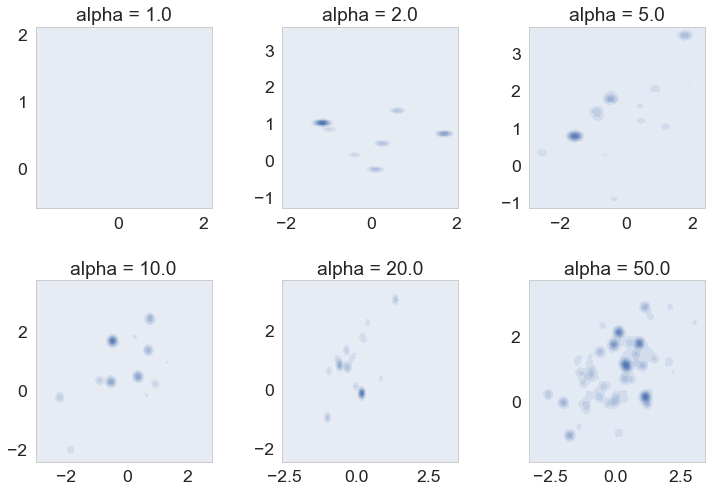

In [20]:
fig = plt.figure(figsize=[12,8])
fig.subplots_adjust(hspace=0.4, wspace=0.4)
i = 1
for alpha in (1,2,5,10,20,50):
    urn = polyaUrn(100000,alpha,np.random.multivariate_normal,[[0,1],[(1,0.5),(0.5,1)]])
    #urn = polyaUrn(1000,alpha,np.random.uniform,[0,1])
    nurn = np.array(urn)
    if alpha <= 2:
        nurn += np.random.uniform(0,0.001,nurn.shape)
    ax = fig.add_subplot(2,3,i)
    sns.kdeplot(nurn,shade=True)
    #sns.plt.scatter(nurn[:,0],nurn[:,1])
    ax.set_title('alpha = %.1f'%alpha)
    i += 1

The key observation here is that while the balls can be selected randomly from a continuous space, the model forces clustering to take place.

### Stick breaking model
For both _CRP_ and _Polya Urn_ models, once the simulation is complete, one can obtain a proportion of data points in each cluster. The _Stick Breaking_ model generates the proportions directly without running the simulation. 

Starting with a stick of unit length, the model draws a sample, $\beta_1$ for the random variable $\beta \sim Beta(1,\alpha)$. The stick is broken off at $\beta_1$. The value of $\beta_1$ is the proportion for the first cluster. The process is repeated on the remaining left portion of the stick, of length $(1 - \beta_1)$ to get proportions for subsequent clusters.

At the end, the proportions for each cluster can be used to assign points to each cluster.

While the _CRP_ and _Polya Urn_ models provide the samples from the posterior distribution $G$, the _Stick Breaking_ model directly gives the distribution.In other words, the stick breaking construction, gives us an explicit form for the posterior distribution $G$:
$$
G(\phi) = \sum_{k=1}^\infty\pi_k \delta(\phi - \phi_k),\text{ where } \phi_k \sim G_0
$$
The mixture weights, $\pi_k$, are generated according to the above described procedure:
\begin{eqnarray}
\beta_k & \sim & \text{Beta}(1,\alpha)\\
\pi_k & = & \beta_k\prod_{l=1}^{k-1}(1-\beta_l)
\end{eqnarray}
One additional result, which will be useful later, is that the sequence ${\bf \pi}$ sums upto 1, and can be used, in principle, as parameters of a Multinomial distribution.

In [4]:
from scipy.stats import beta

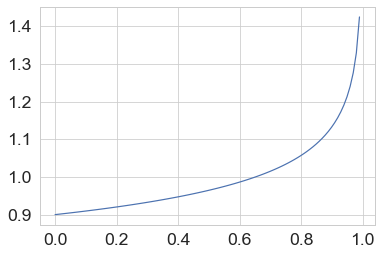

In [11]:
plt.plot(np.linspace(0,1,100),beta(1,0.9).pdf(np.linspace(0,1,100)))

In [12]:
def stickBreaking(numWeights,alpha):
    stickLength = 1
    weights = []
    for n in range(numWeights):
        l = np.random.beta(1,alpha)
        weights.append(l*stickLength)
        stickLength = (1 - l)*stickLength
    return weights

In [22]:
weights = stickBreaking(20,20)

<BarContainer object of 20 artists>

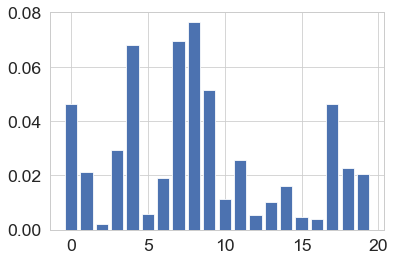

In [23]:
plt.bar(range(20),weights)

### Dirichlet Process
Going back to the Polya Urn model, we see that for a fixed $\alpha$, the simulation gives us a different distribution over the domain of the base distribution, $G_0$. Thus one can consider it as a **distribution over distributions**. This is the definition of a Dirichlet Process. 

Given a base distribution $G_0$ and a concentration parameter $\alpha$, a Dirichlet Process is defined as a distribution, such that a sample $G \sim DP(G_0, \alpha)$ is also a distribution. $\alpha$ controls how far a random sample is away from the base distribution.

### Generative Models for Clustering
We now review how the above discussed models can be used to generate clusters and points belonging to each cluster without making any assumptions about the number of clusters.

To contrast, we will also talk about a fixed sized probabilistic clustering method - Mixture Models.

####  Mixture model based clustering
Sample mixing proportion mixture ($\pi$) from a prior Dirichlet distribution. Sample $k$ distribution parameters for each mixture component. For example, if we assume that the base distribution is Gaussian, we sample $k$ means and $k$ covariance matrices from appropriate prior distributions. For each object, $x_i$, we first sample the cluster from a categorical distribution, parameterized by $\boldsymbol{\pi}$. We then sample the actual value for $x_i$ using the distribution corresponding to the cluster.

#### Chinese Restaurant Process
We first generate cluster assignments for all the points by running the CRP simulation, using $\alpha$ as the concentration parameter. For each cluster/group/table, distribution parameters ($\phi_n$) are sampled from a base distribution $G_0$. For each member of a given cluster, the corresponding observation ($x_i$) is sampled from $F(\phi_n)$.

#### Polya Urn Model
Generate model parameters for each point ($\phi_i$) using the Polya Urn model with base distribution $G_0$ and concentration parameter $\alpha$. Sample $x_i$ from $F(\phi_i)$.

#### Stick Breaking Model
Run the stick-breaking procedure with $\alpha$ as the parameter, arbitrarily large number of times. The resulting probability vector is considered as $\boldsymbol{\pi}$.

### Understanding DP more
$G \sim DP(G_0, \alpha)$ denotes a _Dirichlet Process_ if $G$ is a Dirichlet-distributed random probability measure. Which means that:
1. $G$ is a random probability measure defined over subsets of a space $\mathbb{X}$
2. Consider any finite partitiion of $\mathbb{X}$ (or clustering): $A_1 \cup A_2 \cup \ldots \cup A_k$, we require that $G(A_1), G(A_2), \ldots, G(A_k)$ is distributed using a Dirichlet distribution

Here, $G(A_k)$ denotes the joint probability for the subset $A_k$.
> The second statement seems to connect a DP to a Gaussian Process (GP). For GP, a finite realization from the GP is assumed to be distributed as a Gaussian distribution.




### Inference in Dirichlet Process Mixture
We now discuss the task of inference, i.e., given a set of data points, $x_1, x_2, \ldots, x_N$, find the cluster assignments and cluster parameters. While there are many ways to do this, including multiple Gibbs sampling based methods as well as using variation inference, we will discuss only one of these methods.

### What is Gibbs' Sampling?
Gibbs sampling is a **Markov Chain Monte Carlo** algorithm for sampling from joint distributions, when direct sampling is not possible.

Say you have two random variables, $X$ and $Y$, and $P(X,Y)$ is their joint distribution. We are interested in sampling from $P(X,Y)$ but it is challenging to sampling from it directly. This is a common issue with most non-trivial joint distributions. However, let us suppose that it is relatively easier to sample from the conditional distributions, i.e., $P(X\vert Y)$ and $P(Y\vert X)$. The Gibbs sampler allows you to generate samples from the joint distribution, in an approximate manner, with following steps:
1. Initialize $x_0$ and $y_0$ to some reasonable instantiations for $X$ and $Y$, respectively
2. Sample $x_1 \sim P(X\vert Y=y_0)$ 
3. Sample $y_1 \sim P(Y\vert X=x_1)$
4. Sample $x_2 \sim P(X\vert Y=y_1)$ 
5. Sample $y_2 \sim P(Y\vert X=x_2)$
6. Repeat $M$ times

At the end, you will have $M+1$ samples for $(X,Y)$ - $\{(x_-,y_0),(x_1,y_1),(x_2,y_2),\ldots,(x_M,y_M)\}$. This sequence satisfies the property of being a *Markov Chain*.
> The conditional distribution of $(X_i,Y_i)$ only depends on $(X_{i-1},Y_{i-1})$.

Some properties of the Gibbs sampling procedure:

* These are not i.i.d. samples.
* It would be ideal to sample $(x_0,y_0)$ from a region of high probability under $P(X,Y)$, though this might not always be easy.
* Typically, first $B$ samples are discarded, this is called *burn-in*.
* If you run the chain long enough, choice of $B$ does not matter.

### Gibbs Sampling Approach for FMM
We will first look at a Gibbs sampling based solution for a finite mixture model (FMM), and then extend it for DPMM.

In an FMM set up, we have $N$ observations, $x_1, x_2, \ldots, x_N$ and $N$ unobserved cluster indicators, $z_1, z_2, \ldots, z_N$. We also need to estimate the parameters for each cluster, $\{\theta_k\}_{k=1}^K$ and the mixing weight vector, ${\bf \pi}$.

Following the Gibbs sampling approach, we need conditional probabilities for every unknown parameter. 

\begin{eqnarray}
p(z_i = k\vert {\bf z}_{-k},{\bf x}, \{\theta_k\}_{k=1}^K,{\bf \pi},\alpha,\lambda) & = & p(z_i = k\vert x_i, \pi, \{\theta_k\}_{k=1}^K)\\
& \propto & p(z_i = k \vert {\bf \pi})p(x_i \vert \theta_k)\\
& = & \pi_k F(x_i \vert \theta_k)
\end{eqnarray}
$\alpha$ is the dispersion parameter for the Dirichlet prior for ${\bf \pi}$. $\lambda$ is the parameter for the prior distribution for the cluster parameters.
The above result is possible due to the fact that the posterior for $z_i$ does not depend on any other $z_k$ or $x_k$.

The conditional probability for ${\bf \pi}$ can be written as:
\begin{eqnarray}
p({\bf \pi}\vert {\bf z},{\bf x},\{\theta_k\}_{k=1}^K,\alpha,\lambda) & = & p({\bf \pi}\vert {\bf z}, \{\theta_k\}_{k=1}^K, \alpha)\\
&= & \text{Dir}(n_1 + \frac{\alpha}{K}, \ldots, n_K + \frac{\alpha}{K})
\end{eqnarray}
where $n_k = \sum_{i=1}^N\delta(z_i - k)$. This result is obtained using the fact that the Dirichlet prior for $\pi$ is a conjugate prior for the multinomial distribution, parameterized by $\pi$; the posterior of which is also a Dirichlet distribution.

For the cluster parameters, $\{\theta_k\}_{k=1}^K$, we make use of the known result that the cluster parameters and the mixture weights are conditionally independent of each other, given ${\bf x}_k$ (the observations that currently belong to the $k^{th}$ cluster). Thus,
\begin{eqnarray}
p(\theta_k\vert {\bf z},{\bf x}, {\bf \theta}_{-k}, {\bf \pi},\alpha,\lambda) & = & p(\theta_k\vert {\bf z},{\bf x}, {\bf \theta}_{-k},\lambda)\\
& = & p(\theta_k \vert {\bf x}_k, \lambda)\\
& \propto & G_0(\theta_k\vert \lambda) \prod_{x \in {\bf x}_k} F(x\vert\theta_k)
\end{eqnarray}

Using the above three results, we can implement a simple Gibbs sampling based FMM. One needs to decide on the form of $G_0()$ and $F$. Clearly, having a conjugate pair will certainly make things easier.

For instance, let us assume that $G_0 \sim NW(\mu_0,W,\kappa,\nu)$ and $F(x_i\vert \theta_k) \sim \mathcal{N}(\theta_k \vert I)$. The posterior distribution for $\theta_k$ above will also be a `Normal Inverse Wishart` distribution (See [here](https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf)).


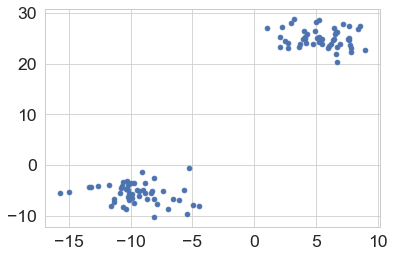

In [102]:
# generate some data
D = 2
C = 2
N = 50
cov  = 5*np.eye(D)
means = np.random.multivariate_normal(np.zeros(D),100*cov,C)
for i in range(C):
    if i == 0:
        samples = np.random.multivariate_normal(means[i,:],cov,N)
    else:
        samples = np.vstack([samples,np.random.multivariate_normal(means[i,:],cov,N)])
plotClusters(samples)

In [139]:
def gibbsMethodFMM(x,K,params,numiters,alpha=1):
    '''
    Gibbs sampling based implementation for Finite Mixture Models. G_0 is assumed to be Gaussian with zero mean
    and identity covariance matrix. The cluster distributions are assumed to be Gaussian with fixed (identity)
    covariance matrix.
    Inputs:
    x - Observed data
    K - number of clusters
    params - tuple containing parameters for the prior G_0
    numiters - number of iternations for the Gibbs sampling
    alpha - dispersion parameter
    '''
    if type(x) == list:
        x = np.array(x)
    if len(x.shape) == 1:
        x = x[:,np.newaxis]
    D = x.shape[1]
    N = x.shape[0]
    
    # Initialize pi, z and thetas
    # sample pi from the Dirichlet prior
    pi = np.random.dirichlet(np.repeat(alpha,K))
    # draw z's from a multinomial parameterized by pi
    z = np.argmax(np.random.multinomial(1,pi,N),axis=1)
    # draw thetas from G_0
    thetas = []
    for k in range(K):
        mu_k,sigma_k = normalinvwishartsample(params)
        thetas.append(tuple((mu_k,sigma_k)))
    for n in range(numiters):
        # simulate one iteration of Gibbs sampling
        # 1 - for each i, draw z_i
        for i in range(N):
            # sample mean and covariance matrix from the posteriors for each cluster
            ps = np.zeros(K)
            for k in range(K):
                ps[k] = mvn(thetas[k][0].flatten(),thetas[k][1]).pdf(x[i:i+1,:])
            if np.sum(ps) == 0:
                ps = ps + 1

            ps1 = np.multiply(ps,pi)
            try:
                z[i] = np.where(np.random.multinomial(1, ps1/np.sum(ps1), size=1)[0] == 1)[0][0]
            except IndexError:
                z[i] = np.random.randint(K)
        # 2 - compute per cluster sizes and draw pi from Dirichlet posterior
        clusterCounts = np.zeros(K)
        for k in range(K):
            clusterCounts[k] = len(np.where(z == k)[0])
        ps = clusterCounts + alpha/K
        pi = np.random.dirichlet(ps)
        # 3 - compute theta for each cluster
        for k in range(K):
            if clusterCounts[k] > 0:
                thetas[k] = normalinvwishartposterior(x[np.where(z == k)[0],:],params)
    return z,pi,thetas

In [140]:
params = (np.array([[ 0.],[ 0.]]),1,0.5*np.array([[ 1.,  0.],[ 0.,  1.]]), 2)

In [143]:
z,pi,thetas = gibbsMethodFMM(samples,2,params,50,1)

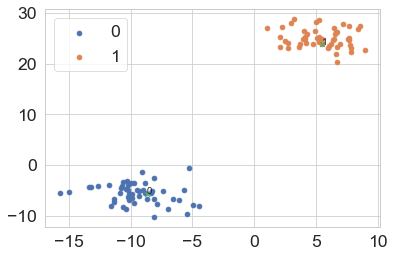

In [144]:
plotClusters(samples,thetas,z)